In [1]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import requests
import sqlite3
import random
import torch

In [10]:
def load_from_database(
        db: str,
        table: str,
        columns: str,
):
    connection = sqlite3.connect('../database/' + db + '.db')
    df = pd.read_sql_query(
        str('SELECT ' + columns + ' FROM ' + table), con=connection
    )
    connection.close()
    return df


def save_to_database(
        db: str,
        table: str,
        df: pd.DataFrame
):
    connection = sqlite3.connect('../database/' + db + '.db')
    try:
        df.to_sql(name=table, con=connection, if_exists='replace')
    except Exception as e:
        raise e
    print('DataFrame has been saved successfully to: ' + db)

### Embed review texts

In [ ]:
df_rev_en_sent = load_from_database(db='review_en_sentiment', table='review_en_sentiment',
                                    columns='wine_id, note, likes_count')
df_rev_en_sent.head()

In [ ]:
len(df_rev_en_sent[df_rev_en_sent['likes_count'] > 0]) / len(df_rev_en_sent)

In [ ]:
print(len(df_rev_en_sent))
df_rev_en_sent = df_rev_en_sent[df_rev_en_sent['likes_count'] > 0]
print(len(df_rev_en_sent))

In [ ]:
embedder = SentenceTransformer.load('../models/zero-shot').to('mps')

In [ ]:
test_embeddings = embedder.encode(
    df_rev_en_sent['note'].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)

In [ ]:
df_rev_en_sent.reset_index(inplace=True)

In [ ]:
#
embeddings_dict = {
    index: [df_rev_en_sent.loc[index, 'wine_id'], test_embeddings[index]] for index in df_rev_en_sent.index
}

In [ ]:
torch.save(embeddings_dict, '../database/test_embeddings_likes.pt')

In [ ]:
torch.save(test_embeddings, '../database/test_embeddings_likes_tensors.pt')

### Load pre-embedded reviews

In [2]:
embeddings_dict: dict = torch.load('../database/test_embeddings_likes.pt')

In [3]:
embeddings_list: torch.tensor = torch.stack([embeddings_dict[i][1] for i in range(len(embeddings_dict.values()))])
wine_id_list: list = [embeddings_dict[i][0] for i in range(len(embeddings_dict.values()))]
del embeddings_dict

In [4]:
embedder = SentenceTransformer.load('../models/simcse_en').to('mps')

In [5]:
random_indices_list = list()
for i in range(200):
    random_index = random.randint(0, len(embeddings_list) - 1)
    random_indices_list.append(random_index)
random_queries = embeddings_list[random_indices_list]

In [6]:
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Palatino'
fig_path = r'/Users/leonbecker/Library/CloudStorage/OneDrive-UniversitätWürzburg/Universität Würzburg/Master Information-Systems/Thesis/LaTex/graphics/'
plt.rcParams['path.simplify'] = True
# locale.setlocale(locale.LC_NUMERIC, "de_DE")
plt.rcParams['axes.formatter.use_locale'] = True

In [7]:
wine_id_count = pd.DataFrame()
for k in [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000]:
    print(k)
    oc1 = list()
    oc2 = list()
    oc3 = list()
    for query in random_queries:
        similarity_scores = util.cos_sim(query, embeddings_list)
        top_results = torch.topk(similarity_scores, k=k)
        top_similar_wines = [wine_id_list[i] for i in top_results[1][0]]

        id_var = max(set(top_similar_wines), key=top_similar_wines.count)
        id_count = top_similar_wines.count(id_var)
        oc1.append(id_count)
        top_similar_wines = [i for i in top_similar_wines if i != id_var]

        id_var = max(set(top_similar_wines), key=top_similar_wines.count)
        id_count = top_similar_wines.count(id_var)
        oc2.append(id_count)
        top_similar_wines = [i for i in top_similar_wines if i != id_var]

        id_var = max(set(top_similar_wines), key=top_similar_wines.count)
        id_count = top_similar_wines.count(id_var)
        oc3.append(id_count)
        top_similar_wines = [i for i in top_similar_wines if i != id_var]

    df_temp = pd.DataFrame(
        {
            'k': [k],
            'mean1': [np.mean(oc1)],
            'mean2': [np.mean(oc2)],
            'mean3': [np.mean(oc3)],
            'median1': [np.median(oc1)],
            'median2': [np.median(oc2)],
            'median3': [np.median(oc3)],
            'total_mean': [np.mean([np.median(oc1), np.median(oc2), np.median(oc3)])]
        }
    )
    wine_id_count = pd.concat([wine_id_count, df_temp])
wine_id_count

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000


,k,mean1,mean2,mean3,median1,median2,median3,total_mean
0,200,6.260,4.495,3.790,4.0,3.0,3.0,3.333333
0,400,9.945,7.425,6.180,6.0,5.0,4.0,5.000000
0,600,13.370,10.020,8.375,8.0,7.0,6.0,7.000000
0,800,16.570,12.770,10.405,10.0,8.0,7.0,8.333333
0,1000,19.850,15.175,12.435,12.0,10.0,8.0,10.000000
0,1200,22.630,17.545,14.335,14.0,11.0,10.0,11.666667
0,1400,25.340,19.620,16.150,15.0,13.0,11.0,13.000000
0,1600,28.360,21.745,18.020,17.0,14.0,12.0,14.333333
0,1800,30.950,24.080,19.920,18.0,15.0,14.0,15.666667
0,2000,33.650,26.250,21.775,20.0,16.5,15.0,17.166667


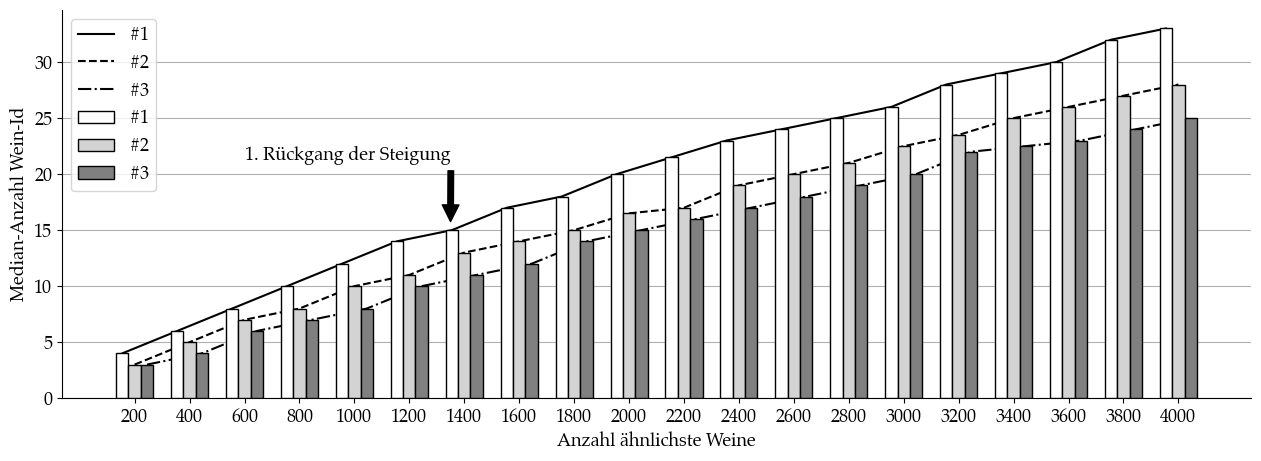

In [28]:
fig, ax = plt.subplots(figsize=(12.8,4.8))
width = 45
ax.bar(
    x=wine_id_count['k']-45,
    height=wine_id_count['median1'] ,
    align='center',
    width=width,
    zorder=3,
    edgecolor='black',
    label='#1',
    color='white'
)
ax.bar(
    x=wine_id_count['k'],
    height=wine_id_count['median2'] ,
    align='center',
    zorder=3,
    width=width,
    edgecolor='black',
    label='#2',
    color='lightgrey'
)
ax.bar(
    x=wine_id_count['k']+45,
    height=wine_id_count['median3'] ,
    align='center',
    width=width,
    zorder=3,
    edgecolor='black',
    label='#3',
    color='grey'
)
ax.plot(
    wine_id_count['k']-45,
    wine_id_count['median1'],
    linestyle='-',
    c='black',
    label='#1'
)
ax.plot(
    wine_id_count['k'],
    wine_id_count['median2'] ,
    linestyle='--',
    c='black',
    label='#2'
)
ax.plot(
    wine_id_count['k']+45,
    wine_id_count['median3'] ,
    linestyle='dashdot',
    c='black',
    label='#3'
)
ax.annotate('1. Rückgang der Steigung', (1350, 15.5),
            xytext=(0.327, 0.65), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=13,
            horizontalalignment='right', verticalalignment='top')
ax.legend(loc='upper left')
ax.set_ylabel('Median-Anzahl Wein-Id')
ax.set_xlabel('Anzahl ähnlichste Weine')
ax.grid(axis='y')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000])
fig.tight_layout()
fig.savefig(fig_path + 'top_k.pdf')

In [61]:
wine_id_count.to_json(orient='columns')

'{"level_0":{"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9},"index":{"0":0,"1":0,"2":0,"3":0,"4":0,"5":0,"6":0,"7":0,"8":0,"9":0},"k":{"0":200,"1":400,"2":600,"3":800,"4":1000,"5":1200,"6":1400,"7":1600,"8":1800,"9":2000},"mean":{"0":5.55,"1":8.7,"2":11.3,"3":14.45,"4":17.35,"5":20.9,"6":23.5,"7":26.45,"8":29.2,"9":32.15},"median":{"0":4.5,"1":6.5,"2":7.5,"3":9.0,"4":10.5,"5":12.5,"6":14.0,"7":16.0,"8":17.0,"9":17.5}}'

In [50]:
wine_id_count.values()

dict_values([[5, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 12, 3, 3, 4, 3, 3, 5, 10, 3], [7, 3, 4, 5, 2, 2, 4, 5, 3, 3, 5, 22, 5, 3, 6, 5, 3, 6, 14, 4], [11, 4, 5, 8, 3, 4, 4, 5, 4, 3, 6, 28, 5, 4, 8, 6, 4, 7, 17, 8], [15, 4, 7, 8, 4, 5, 5, 6, 4, 5, 6, 33, 9, 4, 11, 7, 5, 7, 20, 9], [15, 4, 7, 9, 5, 5, 5, 7, 6, 5, 7, 39, 10, 5, 16, 7, 6, 7, 21, 10], [17, 5, 7, 11, 6, 6, 6, 7, 7, 6, 8, 46, 11, 6, 21, 8, 7, 8, 23, 10], [19, 5, 7, 15, 7, 6, 6, 8, 7, 6, 8, 56, 14, 6, 24, 11, 8, 9, 25, 11], [22, 7, 7, 17, 7, 6, 7, 9, 7, 6, 11, 63, 19, 6, 30, 11, 8, 9, 25, 12], [24, 7, 7, 20, 7, 7, 8, 9, 7, 6, 13, 71, 23, 7, 31, 16, 10, 9, 26, 14], [26, 9, 7, 22, 8, 7, 8, 9, 7, 6, 17, 78, 24, 7, 33, 16, 11, 10, 28, 14]])

In [ ]:
probabilities =  [top_results[0][0][i] for i in indices]
np.round(np.mean(probabilities), decimals=2)

In [ ]:
wine_ids = list()
lower, upper = 0, 1000
for i in range(3):
    wines = top_similar_wines[lower:upper]
    id_var = max(set(wines), key=wines.count)
    while id_var in wine_ids:
        wines = [i for i in wines if i != id_var]
        id_var = max(set(wines), key=wines.count)
    wine_ids.append(id_var)
    lower += 1000
    upper += 1000

In [ ]:
query = 'light white wine with creamy texture low acidity fruity'
embedded_query = embedder.encode(query, convert_to_tensor=True)

In [ ]:
time_dict = dict()
k = 100
for n in [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]:
    embeddings_list_test = embeddings_list[:n]
    time_dict[n] = list()
    for i in range(50):
        start = datetime.now()
        similarity_scores = util.cos_sim(a=embedded_query, b=embeddings_list_test)
        top_similar_wines = torch.topk(k=k, input=similarity_scores)
        duration = datetime.now() - start
        time_dict[n].append(duration)

In [ ]:
time_dict

In [ ]:
df_dict = dict()
for key in time_dict.keys():
    df_dict[key] = np.median([i.microseconds for i in time_dict[key]])

In [3]:
# 2620, 1667464
USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15'
prices = requests.get(
    url='https://www.vivino.com/api/wines/{}/checkout_prices?language=de'.format(1667464),
    headers={
        'User-Agent': USER_AGENT
    }
).json()

In [48]:
if prices.json()['checkout_prices'][0]['availability']['price']:
    price = 'Vorhanden (price)!'
elif prices.json()['checkout_prices'][0]['availability']['median']:
    price = 'Vorhanden (median)!'
else:
    price = 'Fehlt!'
price

'Vorhanden (median)!'

In [10]:
highlights = requests.get(
    url='https://www.vivino.com/api/wines/{}/highlights?per_page=1'.format(1667464),
    headers={
        'User-Agent': USER_AGENT
    }
).json()

In [9]:
if highlights['highlights'][0]['metadata']['style']:
    wine_type = highlights['highlights'][0]['metadata']['style']
else:
    wine_type = 'k.A.'
wine_type

'k.A.'

In [1]:
from datetime import datetime

datetime.now().isoformat(sep=" ", timespec="seconds")

'2023-03-23 15:55:41'